# 爬取研报

In [7]:
import pandas as pd
import atrader as at
import numpy as np
from eastmoney_scraper_many1 import EastmoneyReportScraper

In [8]:
def get_eastmoney_data(start_date="2025-04-09 00:00:00", end_date="2025-04-10 00:00:00", output_file="eastmoney_report_data.xlsx", desired_count=1):
    # 初始化爬虫(可传入自定义cookie)
    scraper = EastmoneyReportScraper()
    scraper.scrape( start_date, end_date, output_file, desired_count=desired_count)

In [ ]:
if __name__ == '__main__':
    start_date = '2025-01-01'
    end_date = '2025-01-31'
    output_file = 'eastmoney_report_data.xlsx'
    desired_count = 500

    # 获取研报数据
    get_eastmoney_data(start_date, end_date, output_file, desired_count=desired_count)

正在爬取 2025-01-24 的数据...
正在获取第 1 页数据...
请求状态码： 200
正在下载：https://pdf.dfcfw.com/pdf/H3_AP202501241642534058_1.pdf?1749197640851.pdf （第 1 份文件）
下载成功：d:\WPS云盘\482716163\WPS云盘\论文投稿+科研申报\论文投稿\毕设投稿\SCI\情感词典\2025-01-24_2025-01-25\000983-2024年业绩预告点评：24年业绩同比下滑，长期发展值得关注-2025-01-24.pdf
正在下载：https://pdf.dfcfw.com/pdf/H3_AP202501241642533817_1.pdf?1749197643554.pdf （第 2 份文件）
下载成功：d:\WPS云盘\482716163\WPS云盘\论文投稿+科研申报\论文投稿\毕设投稿\SCI\情感词典\2025-01-24_2025-01-25\605337-品牌焕新渠道求变，静待成效显现-2025-01-24.pdf
正在下载：https://pdf.dfcfw.com/pdf/H3_AP202501241642532099_1.pdf?1749197645203.pdf （第 3 份文件）
下载成功：d:\WPS云盘\482716163\WPS云盘\论文投稿+科研申报\论文投稿\毕设投稿\SCI\情感词典\2025-01-24_2025-01-25\000560-公司信息更新报告：归母净利润扭亏为盈，在管房源同比增长-2025-01-24.pdf
正在下载：https://pdf.dfcfw.com/pdf/H3_AP202501241642531030_1.pdf?1749197646845.pdf （第 4 份文件）
下载成功：d:\WPS云盘\482716163\WPS云盘\论文投稿+科研申报\论文投稿\毕设投稿\SCI\情感词典\2025-01-24_2025-01-25\300413-公司点评报告：会员业务创新高，广告业务回暖-2025-01-24.pdf
正在下载：https://pdf.dfcfw.com/pdf/H3_AP202501241642531019_1.pdf?1749197649125.pdf （第 5 份文

# 生成情感词典

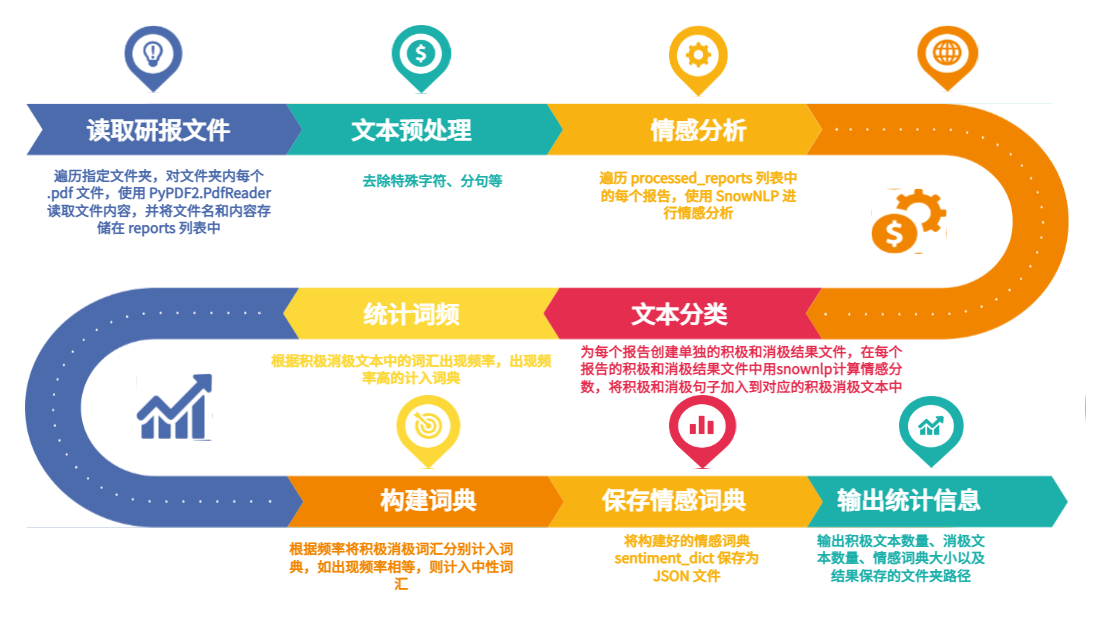

In [11]:
import os
import re
import json
from datetime import datetime
from collections import defaultdict
import jieba
import numpy as np
from snownlp import SnowNLP
from gensim.models import KeyedVectors
import PyPDF2

从文件夹读取研报

In [12]:
def read_reports_from_folder(folder_path):
    reports = []
    # 使用 os.walk 函数遍历指定文件夹及其子文件夹
    # os.walk 函数返回一个三元组 (root, dirs, files)
    # root 表示当前正在遍历的文件夹路径
    # dirs 是一个列表，包含当前文件夹中的子文件夹名称
    # files 是一个列表，包含当前文件夹中的文件名称
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.pdf'):
                file_path = os.path.join(root, file) # 把多个路径组件组合成一个有效的路径字符串
                try:
                    with open(file_path, 'rb') as f:  # 注意这里是二进制模式'rb'
                        reader = PyPDF2.PdfReader(f)
                        content = ""
                        for page in reader.pages:
                            content += page.extract_text()
                        reports.append({
                            'filename': file,
                            'content': content
                        })
                except Exception as e:
                    print(f"读取文件 {file_path} 时出错: {e}")
    return reports

分句处理

In [13]:
def preprocess_text(text):
    """
    预处理文本并分句
    1. 去除特殊字符（保留中英文和数字）
    2. 去除多余空格
    3. 中文分句处理（基于常见标点）
    """
    # 去除特殊字符（保留中英文、数字和基本标点）
    text = re.sub(r'[^\u4e00-\u9fa5a-zA-Z0-9，。！？；：、]', ' ', text)
    
    # 去除多余空格，\s+ 表示匹配一个或多个连续的空白字符
    text = re.sub(r'\s+', ' ', text).strip()    
    
    # 中文分句处理（按常见标点分割）
    sentences = re.split(r'([。！？；：])', text)
    
    # 重组句子（将标点重新附加到前一句）
    processed_sentences = []
    for i in range(0, len(sentences)-1, 2):
        sentence = sentences[i] + (sentences[i+1] if i+1 < len(sentences) else '')
        if sentence.strip():  # 去除空句子
            processed_sentences.append(sentence.strip())
    
    # 如果奇数个元素，处理最后一个
    if len(sentences) % 2 != 0 and sentences[-1].strip():
        processed_sentences.append(sentences[-1].strip())
    
    return processed_sentences

初步构建金融情感词典

In [14]:
def is_chinese_word(word):
    
    """检查是否为纯中文词汇"""
    for char in word:
        if not '\u4e00' <= char <= '\u9fff':
            return False
    return True

def build_sentiment_dictionary(positive_texts, negative_texts, min_freq=3):
    """
    构建情感词典（只保留纯中文词汇）
    positive_texts: 积极文本列表
    negative_texts: 消极文本列表
    min_freq: 最小出现频率
    """
    # 创建统计词频字典
    pos_word_freq = defaultdict(int)
    neg_word_freq = defaultdict(int)
    
    # 分析积极文本
    for text in positive_texts:
        words = jieba.lcut(text)
        for word in words:
            # 只保留长度大于1的纯中文词
            if len(word) > 1 and is_chinese_word(word):
                pos_word_freq[word] += 1
    
    # 分析消极文本
    for text in negative_texts:
        words = jieba.lcut(text)
        for word in words:
            # 只保留长度大于1的纯中文词
            if len(word) > 1 and is_chinese_word(word):
                neg_word_freq[word] += 1
    
    # 构建情感词典
    sentiment_dict = {}
    
    # 添加积极词汇
    for word, freq in pos_word_freq.items():
        if freq >= min_freq and word not in sentiment_dict:
            sentiment_dict[word] = {
                'sentiment': 'positive',
                'frequency': freq,
                'source': 'auto_generated'
            }
    
    # 添加消极词汇
    for word, freq in neg_word_freq.items():
        if freq >= min_freq:
            if word in sentiment_dict:
                # 如果同一个词在积极和消极中都出现，比较频率
                if freq > sentiment_dict[word]['frequency']:
                    sentiment_dict[word] = {
                        'sentiment': 'negative',
                        'frequency': freq,
                        'source': 'auto_generated'
                    }
            else:
                sentiment_dict[word] = {
                    'sentiment': 'negative',
                    'frequency': freq,
                    'source': 'auto_generated'
                }
    
    return sentiment_dict


初步标注情感标签

In [19]:
if __name__ == '__main__':
    output_file = '2025-01-24_2025-01-25/'
    
    # 创建保存目录
    save_dir = os.path.join(output_file, 'sentiment_results')
    os.makedirs(save_dir, exist_ok=True)
    
    # 初始化存储
    positive_texts = []
    negative_texts = []
    
    # 从文件夹读取研报
    reports = read_reports_from_folder(output_file)
    processed_reports = []
    
    for report in reports:
        # 对每个报告的内容进行分句预处理
        processed_content = preprocess_text(report['content'])
        processed_reports.append({
            'filename': report['filename'],
            'content': processed_content  # 这是一个句子列表
        })

    # 情感分析并分类保存文本
    for report in processed_reports:
        print(f"\n分析文件: {report['filename']}")
        
        # 为每个报告创建单独的积极和消极结果文件
        report_name = os.path.splitext(report['filename'])[0]
        pos_file = os.path.join(save_dir, f"{report_name}_positive.txt")
        neg_file = os.path.join(save_dir, f"{report_name}_negative.txt")
        # 在每个报告的积极和消极结果文件中用snownlp计算情感分数，将积极和消极句子加入到对应的积极消极文本中
        with open(pos_file, 'w', encoding='utf-8') as f_pos, \
             open(neg_file, 'w', encoding='utf-8') as f_neg:
            
            for i, sentence in enumerate(report['content'], 1):
                if len(sentence) < 5:
                    continue
                    
                try:
                    s = SnowNLP(sentence)
                    sentiment_score = s.sentiments
                    
                    if sentiment_score >= 0.7:
                        f_pos.write(f"{sentiment_score:.4f}\t{sentence}\n")
                        positive_texts.append(sentence)
                    elif sentiment_score <= 0.3:
                        f_neg.write(f"{sentiment_score:.4f}\t{sentence}\n")
                        negative_texts.append(sentence)
                        
                except Exception as e:
                    print(f"分析句子 {i} 时出错: {str(e)}")
                    continue
    
    # 构建情感词典（根据积极消极文本中的词汇出现频率，出现频率高的计入词典）
    sentiment_dict = build_sentiment_dictionary(positive_texts, negative_texts)
    
    # 保存情感词典
    dict_file = os.path.join(save_dir, 'financial_sentiment_dict.json')
    with open(dict_file, 'w', encoding='utf-8') as f:
        json.dump(sentiment_dict, f, ensure_ascii=False, indent=2)    # json.dump()将 Python 对象（通常是字典或列表）转换为 JSON 格式的字符串，设置为 False 时，非 ASCII 字符会按原样输出，这样可以正确显示中文、日文等非 ASCII 字符
    
    print("\n情感词典构建完成:")
    print(f"- 积极文本数量: {len(positive_texts)}")
    print(f"- 消极文本数量: {len(negative_texts)}")
    print(f"- 情感词典大小: {len(sentiment_dict)}")
    print(f"结果已保存到: {save_dir}")

Illegal character in Name Object (b'/ABCDEE+\xe6\x96\xb9\xe6\xad\xa3\xe6\x96\xb0\xe4\xb9\xa6\xe5\xae\x8b\xe7\xae')



分析文件: 000423-公司点评报告：未来业绩稳步增长可期-2025-01-24.pdf

分析文件: 000543-2024年业绩预告点评：归母同增40%-57%，机组投产利润加速-2025-01-24.pdf

分析文件: 000543-业绩超预期 EPS仍有增长-2025-01-24.pdf

分析文件: 000560-公司信息更新报告：归母净利润扭亏为盈，在管房源同比增长-2025-01-24.pdf

分析文件: 000603-资源开发贡献增量，2024业绩预告同比高增-2025-01-24.pdf

分析文件: 000983-2024年业绩预告点评：24年业绩同比下滑，长期发展值得关注-2025-01-24.pdf

分析文件: 001286-煤电一体化发展成本优势较强，产能增长空间大-2025-01-24.pdf

分析文件: 002127-国民品牌，反转焕新-2025-01-24.pdf

分析文件: 002387-公司动态跟踪点评：重大资产重组有序推进，公司积极响应OLED中尺寸需求-2025-01-24.pdf

分析文件: 002497-2024年业绩预告点评：Q4锂业务扭亏，25年销量预计维持高增-2025-01-24.pdf

分析文件: 002497-氢氧化锂龙头之一，锂矿增量贡献业绩成长空间-2025-01-25.pdf

分析文件: 002517-深度报告：“传奇+IP”品类双线并行，拥抱AIXR创新技术-2025-01-24.pdf

分析文件: 002847-从产品的角度解析公司增长潜力：多品类大单品不断打造增长曲线-2025-01-24.pdf

分析文件: 002865-2024年业绩预告点评：Q4环比减亏，25年有望回暖-2025-01-24.pdf

分析文件: 003006-25年趋势延续逻辑加强-2025-01-24.pdf

分析文件: 003006-百亚股份：舆情影响趋弱，长期成长无虞-2025-01-24.pdf

分析文件: 300058-公司事件点评报告：2024年收入超600亿元 2025年乘AI东风续写龙头之姿-2025-01-24.pdf

分析文件: 300413-公司点评报告：会员业务创新高，广告业务回暖-2025-01-24.pdf

分析文件: 300438-计提减值影响利润，轻装上阵再出发

Building prefix dict from the default dictionary ...



分析文件: 837403-康农种业点评报告：产品放量及毛利率改善带来业绩超预期增长-2025-01-24.pdf


Dumping model to file cache C:\Users\songz\AppData\Local\Temp\jieba.cache
Loading model cost 0.620 seconds.
Prefix dict has been built successfully.



情感词典构建完成:
- 积极文本数量: 4857
- 消极文本数量: 3740
- 情感词典大小: 4177
结果已保存到: 2025-01-24_2025-01-25/sentiment_results


# 扩充情感词典
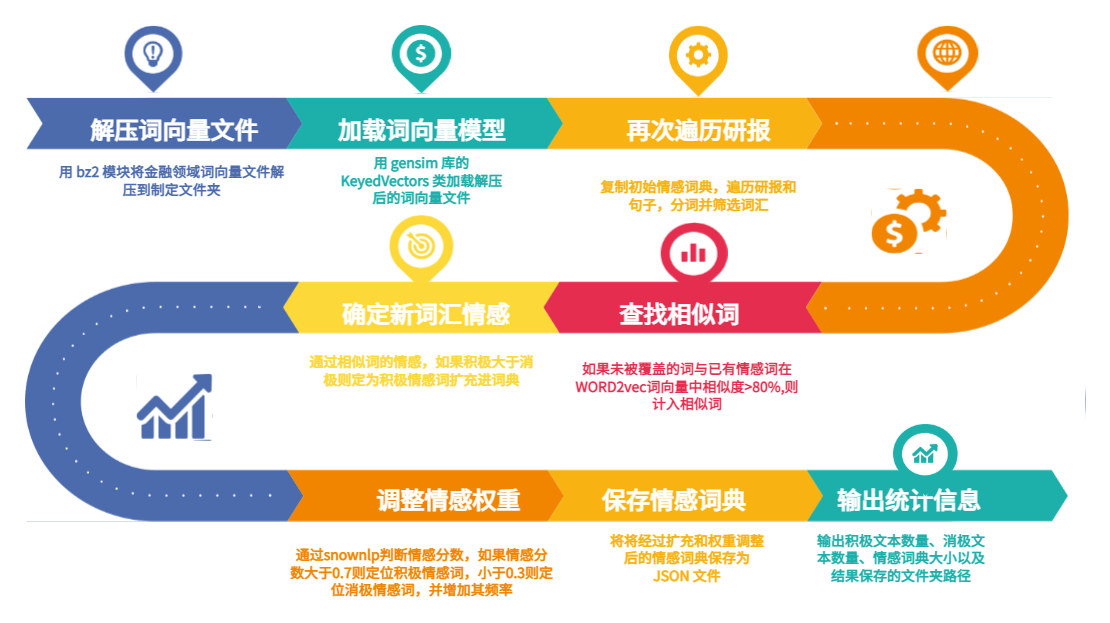

In [22]:
import bz2

# 输入的压缩文件路径
compressed_file = 'sgns.financial.word.bz2'
# 解压后的文件路径
decompressed_file = 'sgns.financial.word'

with bz2.open(compressed_file, 'rb') as f_in:       # rb 表示以只读二进制模式打开
    with open(decompressed_file, 'wb') as f_out:   # wb 表示以写入二进制模式打开
        f_out.write(f_in.read())        # 将压缩文件中的所有内容读取出来，然后写入到解压后的文件中

print("文件解压完成。")

文件解压完成。


In [23]:
from gensim.models import KeyedVectors

# 加载解压后的词向量文件
model = KeyedVectors.load_word2vec_format('sgns.financial.word', binary=False)

# 测试加载是否成功，获取某个词的词向量
word = 'pvc'
if word in model:
    vector = model[word]
    print(f"词 '{word}' 的词向量维度: {vector.shape}")
    print(f"词 '{word}' 的词向量: {vector}")
else:
    print(f"词 '{word}' 不在词向量模型中。")

词 'pvc' 的词向量维度: (300,)
词 'pvc' 的词向量: [-7.467610e-01  9.561700e-02  8.074300e-02  7.818500e-02 -7.825000e-03
  2.139480e-01  1.555030e-01  4.350600e-02  2.549170e-01 -4.196230e-01
 -3.565020e-01  1.978010e-01 -3.946990e-01  9.832150e-01  1.291700e-01
 -4.157480e-01  9.440500e-02  3.833200e-02 -2.169650e-01  7.666000e-03
 -2.105910e-01 -1.724210e-01  5.056130e-01  4.897410e-01  1.020440e-01
 -2.261060e-01  1.842670e-01  1.464560e-01 -3.058570e-01 -3.768370e-01
 -6.736990e-01 -2.711400e-01  3.620040e-01  7.512800e-02  9.487380e-01
 -3.001270e-01 -5.997100e-02  1.242230e-01  9.015400e-02 -4.399110e-01
  2.250790e-01  8.024300e-01 -3.206690e-01  4.340410e-01  1.404280e-01
 -2.228100e-02 -4.312870e-01 -3.221850e-01  1.820240e-01  8.766000e-03
 -3.157700e-01  7.544840e-01  8.426900e-02  3.289110e-01  2.217620e-01
  1.319680e-01 -7.781330e-01 -4.188500e-02  1.642360e-01  8.453200e-02
  4.743230e-01  9.446710e-01  4.425590e-01  3.002060e-01  3.068220e-01
 -2.893980e-01 -6.102830e-01 -5.423140e-

词典构建与扩展

In [24]:
def expand_sentiment_dictionary(sentiment_dict, reports, word2vec_model, min_similarity=0.8):
    """
    通过分析研报中未被初始情感词典涵盖的情感词汇，借助WORD2vec词向量模型扩充词典
    sentiment_dict: 初始情感词典
    reports: 处理后的研报列表
    word2vec_model: Word2Vec词向量模型
    min_similarity: 最小相似度阈值
    return: 扩充后的情感词典
    """
    new_sentiment_dict = sentiment_dict.copy()
    for report in reports:
        for sentence in report['content']:
            words = jieba.lcut(sentence)
            for word in words:
                if len(word) > 1 and is_chinese_word(word) and word not in new_sentiment_dict:
                    similar_words = []
                    try:
                        # 查找与已知情感词汇相似的词
                        for known_word in sentiment_dict.keys():
                            if word2vec_model.has_index_for(known_word) and word2vec_model.has_index_for(word):  # has_index_for指词向量表示
                                similarity = word2vec_model.similarity(known_word, word)
                                if similarity >= min_similarity:
                                    similar_words.append((known_word, similarity))
                    except KeyError:
                        continue

                    if similar_words:
                        # 根据相似词的情感确定新词汇的情感
                        pos_count = sum([1 for known_word, _ in similar_words if sentiment_dict[known_word]['sentiment'] == 'positive'])
                        neg_count = sum([1 for known_word, _ in similar_words if sentiment_dict[known_word]['sentiment'] == 'negative'])
                        if pos_count > neg_count:
                            new_sentiment_dict[word] = {
                               'sentiment': 'positive',
                                'frequency': 1,
                               'source': 'expanded_by_word2vec'
                            }
                        elif neg_count > pos_count:
                            new_sentiment_dict[word] = {
                               'sentiment': 'negative',
                                'frequency': 1,
                               'source': 'expanded_by_word2vec'
                            }
                        else:
                            new_sentiment_dict[word] = {
                               'sentiment': 'neutral',
                                'frequency': 1,
                               'source': 'expanded_by_word2vec'
                            }
                    else:
                        new_sentiment_dict[word] = {
                           'sentiment': 'neutral',
                            'frequency': 1,
                           'source': 'new_word'
                        }
    return new_sentiment_dict

In [25]:
def adjust_sentiment_weights(sentiment_dict, reports):
    """
    根据词汇在不同语境中的情感表现，调整其在词典中的权重
    sentiment_dict: 情感词典
    reports: 处理后的研报列表
    return: 调整权重后的情感词典
    """
    for report in reports:
        for sentence in report['content']:
            words = jieba.lcut(sentence)
            s = SnowNLP(sentence)
            sentiment_score = s.sentiments
            for word in words:
                if word in sentiment_dict:
                    if sentiment_score >= 0.7:
                        if sentiment_dict[word]['sentiment'] == 'positive':
                            sentiment_dict[word]['frequency'] += 1
                    elif sentiment_score <= 0.3:
                        if sentiment_dict[word]['sentiment'] == 'negative':
                            sentiment_dict[word]['frequency'] += 1
    return sentiment_dict

In [26]:
if __name__ == '__main__':

    # 加载Word2Vec词向量模型
    word2vec_model =  KeyedVectors.load_word2vec_format('sgns.financial.word', binary=False)

    # 扩充情感词典（如果未被覆盖的词与已有情感词在WORD2vec词向量中相似度>80%,则计入相似词，通过相似词的情感，如果积极大于消极则定为积极情感词扩充进词典)
    sentiment_dict = expand_sentiment_dictionary(sentiment_dict, processed_reports, word2vec_model)

    # 调整情感权重(通过snownlp判断情感分数，如果情感分数大于0.7则定位积极情感词，小于0.3则定位消极情感词，并增加其频率)
    sentiment_dict = adjust_sentiment_weights(sentiment_dict, processed_reports)

    # 保存情感词典
    dict_file = os.path.join(save_dir, 'financial_sentiment_dict.json')
    with open(dict_file, 'w', encoding='utf-8') as f:
        json.dump(sentiment_dict, f, ensure_ascii=False, indent=2)   # json.dump()将 Python 对象（通常是字典或列表）转换为 JSON 格式的字符串

    print("\n情感词典构建完成:")
    print(f"- 积极文本数量: {len(positive_texts)}")
    print(f"- 消极文本数量: {len(negative_texts)}")
    print(f"- 情感词典大小: {len(sentiment_dict)}")
    print(f"结果已保存到: {save_dir}")


情感词典构建完成:
- 积极文本数量: 4857
- 消极文本数量: 3740
- 情感词典大小: 11434
结果已保存到: 2025-01-24_2025-01-25/sentiment_results


In [ ]:
# ---------------------- 一、导入依赖库 ----------------------
import pandas as pd
import jieba
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from tqdm import tqdm
import json
from pathlib import Path


# ---------------------- 二、超参数配置 ----------------------
# 路径配置
DATA_PATH = "PVC_股吧数据_2020-2024.xlsx"  # 股吧数据路径（Excel/CSV）
DICT_PATH = "2025-01-24_2025-01-25/sentiment_results/financial_sentiment_dict.json"  # 情感词典路径
STOPWORDS_PATH = "停用词.txt"  # 停用词表路径
OUTPUT_PATH = "PVC数据带情感得分.csv"  # 最终输出路径

# 模型参数
EMBED_DIM = 100  # 词向量维度
HIDDEN_DIM = 256  # LSTM隐藏层维度
BATCH_SIZE = 32  # 批次大小
EPOCHS = 20  # 训练轮次
MAX_LEN = 20  # 文本最大长度（标题通常较短）
EARLY_STOPPING_PATIENCE = 3  # 早停耐心值


# ---------------------- 三、工具函数定义 ----------------------
def load_stopwords(path):
    """加载停用词表"""
    with open(path, 'r', encoding='utf-8') as f:
        return set(f.read().splitlines())

def preprocess_text(text, stopwords):
    """文本预处理：分词+过滤停用词"""
    text = str(text).strip()
    if not text:
        return []
    words = jieba.lcut(text)
    # 保留单字情感词（如"涨""跌"），仅过滤无意义停用词
    return [word for word in words if word not in stopwords or len(word) >= 1]

def load_sentiment_dict(path):
    """加载情感词典并转换为{词: (情感倾向, 频率)}"""
    with open(path, 'r', encoding='utf-8') as f:
        raw_dict = json.load(f)
    return {word: (info['sentiment'], info['frequency']) for word, info in raw_dict.items()}

def generate_pseudo_labels(tokens, sent_dict):
    """根据情感词数量生成伪标签（积极/消极/中性）"""
    pos_count = sum(1 for word in tokens if sent_dict.get(word, (None,))[0] == 'positive')
    neg_count = sum(1 for word in tokens if sent_dict.get(word, (None,))[0] == 'negative')
    if pos_count > neg_count:
        return 2  # 积极
    elif neg_count > pos_count:
        return 1  # 消极
    else:
        return 0  # 中性


# ---------------------- 四、数据加载与预处理 ----------------------
# 1. 加载基础数据
print("===== 数据加载与清洗 =====")
try:
    if Path(DATA_PATH).suffix == '.xlsx':
        df = pd.read_excel(DATA_PATH)
    else:
        df = pd.read_csv(DATA_PATH)
except FileNotFoundError:
    raise ValueError(f"文件未找到：{DATA_PATH}，请检查路径")

# 2. 数据清洗
df = df.dropna(subset=['标题']).drop_duplicates(subset=['标题']).reset_index(drop=True)
print(f"清洗后有效数据量: {len(df)}")

# 3. 加载停用词和情感词典
stopwords = load_stopwords(STOPWORDS_PATH)
sent_dict = load_sentiment_dict(DICT_PATH)

# 4. 文本预处理
df['tokens'] = df['标题'].apply(lambda x: preprocess_text(x, stopwords))
df = df[df['tokens'].apply(len) > 0].reset_index(drop=True)  # 过滤空分词结果
print(f"有效分词数据量: {len(df)}")

# 5. 生成伪标签（替代随机标签）
df['label'] = df['tokens'].apply(lambda x: generate_pseudo_labels(x, sent_dict))
print("标签分布:")
print(df['label'].value_counts())


# ---------------------- 五、词向量训练 ----------------------
print("\n===== 训练Word2Vec词向量 =====")
sentences = df['tokens'].tolist()
w2v_model = Word2Vec(
    sentences,
    vector_size=EMBED_DIM,
    window=5,
    min_count=1,
    workers=4,
    sg=1  # 使用Skip-gram模型
)
vocab = w2v_model.wv.key_to_index
word2idx = {word: idx+1 for idx, word in enumerate(vocab)}  # 索引从1开始（0为PAD）
word2idx['<PAD>'] = 0
print(f"词汇表大小: {len(word2idx)}")


# ---------------------- 六、构建数据集（融合情感特征） ----------------------
class SentimentDataset(Dataset):
    def __init__(self, df, word2idx, sent_dict, max_len):
        # 1. 词索引序列
        self.input_ids = [
            [word2idx.get(word, 0) for word in tokens] + [0]*(max_len - len(tokens)) 
            if len(tokens) < max_len else [word2idx.get(word, 0) for word in tokens[:max_len]]
            for tokens in df['tokens']
        ]
        self.input_ids = torch.LongTensor(self.input_ids)
        
        # 2. 情感统计特征（积极词数量、消极词频率总和）
        self.pos_counts = torch.FloatTensor([
            sum(1 for word in tokens if sent_dict.get(word, (None,))[0] == 'positive')
            for tokens in df['tokens']
        ]).unsqueeze(1)  # 形状：(n, 1)
        
        self.neg_weights = torch.FloatTensor([
            sum(sent_dict[word][1] for word in tokens if sent_dict.get(word, (None,))[0] == 'negative')
            for tokens in df['tokens']
        ]).unsqueeze(1)  # 形状：(n, 1)
        
        # 3. 标签
        self.labels = torch.LongTensor(df['label'].values)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'pos_count': self.pos_counts[idx],
            'neg_weight': self.neg_weights[idx],
            'label': self.labels[idx]
        }


# ---------------------- 七、定义融合情感特征的LSTM模型 ----------------------
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, sent_feat_dim=2):
        super().__init__()
        # 词嵌入层（使用Word2Vec预训练）
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # LSTM层（双向）
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
            dropout=0.2
        )
        
        # 情感特征处理层（将2维情感特征映射到LSTM输出维度）
        self.sent_fc = nn.Linear(sent_feat_dim, hidden_dim * 2)  # 双向LSTM输出维度为hidden_dim*2
        
        # 分类头（融合LSTM特征和情感特征）
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2 + hidden_dim * 2, 128),  # 拼接LSTM输出和情感特征
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        # 词嵌入：(batch_size, seq_len, embed_dim)
        embeds = self.embedding(x['input_ids'])
        
        # LSTM处理：out形状 (batch_size, seq_len, hidden_dim*2)
        out, _ = self.lstm(embeds)
        lstm_feat = out[:, -1, :]  # 取最后一个时间步的隐藏状态
        
        # 情感特征处理：(batch_size, 2) → (batch_size, hidden_dim*2)
        sent_feat = torch.cat([x['pos_count'], x['neg_weight']], dim=1)
        sent_feat = self.sent_fc(sent_feat)
        
        # 融合特征并分类
        combined_feat = torch.cat([lstm_feat, sent_feat], dim=1)
        return self.classifier(combined_feat)


# ---------------------- 八、模型训练与验证 ----------------------
# 1. 划分训练集和验证集（分层抽样）
print("\n===== 准备训练数据 =====")
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss.split(df, df['label']))
train_df = df.iloc[train_idx]
val_df = df.iloc[val_idx]

# 2. 创建数据集和数据加载器
train_dataset = SentimentDataset(train_df, word2idx, sent_dict, MAX_LEN)
val_dataset = SentimentDataset(val_df, word2idx, sent_dict, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 3. 初始化模型与训练配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SentimentLSTM(
    vocab_size=len(word2idx),
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=3  # 三分类：中性、消极、积极
).to(device)

# 加载预训练词向量（可选）
embedding_matrix = np.zeros((len(word2idx), EMBED_DIM))
for word, idx in word2idx.items():
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # 降低学习率

# 4. 训练循环（含早停机制）
print("\n===== 开始训练 =====")
best_val_acc = 0.0
no_improvement = 0

for epoch in range(EPOCHS):
    # 训练阶段
    model.train()
    total_train_loss = 0
    with tqdm(train_loader, unit='batch') as tepoch:
        for batch in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")
            
            # 数据加载到设备
            input_ids = batch['input_ids'].to(device)
            pos_count = batch['pos_count'].to(device)
            neg_weight = batch['neg_weight'].to(device)
            labels = batch['label'].to(device)
            
            # 前向传播+反向优化
            optimizer.zero_grad()
            outputs = model({'input_ids': input_ids, 'pos_count': pos_count, 'neg_weight': neg_weight})
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())

    # 验证阶段
    model.eval()
    total_val_correct = 0
    total_val_samples = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            pos_count = batch['pos_count'].to(device)
            neg_weight = batch['neg_weight'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model({'input_ids': input_ids, 'pos_count': pos_count, 'neg_weight': neg_weight})
            preds = torch.argmax(outputs, dim=1)
            total_val_correct += (preds == labels).sum().item()
            total_val_samples += labels.size(0)
    
    val_acc = total_val_correct / total_val_samples
    train_loss = total_train_loss / len(train_loader)
    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Acc={val_acc:.4f}")

    # 早停检查
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_improvement = 0
        torch.save(model.state_dict(), 'best_sentiment_model.pth')
        print(f"模型已保存（验证准确率提升至{val_acc:.4f}）")
    else:
        no_improvement += 1
        if no_improvement >= EARLY_STOPPING_PATIENCE:
            print(f"早停触发：验证准确率连续{EARLY_STOPPING_PATIENCE}轮未提升")
            break

print(f"\n训练完成，最佳验证准确率: {best_val_acc:.4f}")


# ---------------------- 九、情感预测与结果输出 ----------------------
def predict_sentiment(titles, model, word2idx, sent_dict, max_len, device):
    """对新标题进行情感预测"""
    model.eval()
    scores = []
    with torch.no_grad():
        for title in tqdm(titles, desc="预测中"):
            # 预处理
            tokens = preprocess_text(title, stopwords)
            input_ids = [word2idx.get(word, 0) for word in tokens]
            input_ids = input_ids[:max_len] + [0]*(max_len - len(input_ids)) if len(input_ids) < max_len else input_ids[:max_len]
            input_ids = torch.LongTensor([input_ids]).to(device)
            
            # 情感特征计算
            pos_count = torch.FloatTensor([[sum(1 for word in tokens if sent_dict.get(word, (None,))[0] == 'positive')]]).to(device)
            neg_weight = torch.FloatTensor([[sum(sent_dict[word][1] for word in tokens if sent_dict.get(word, (None,))[0] == 'negative')]]).to(device)
            
            # 模型预测
            outputs = model({'input_ids': input_ids, 'pos_count': pos_count, 'neg_weight': neg_weight})
            probs = torch.softmax(outputs, dim=1).cpu().numpy()[0]
            scores.append(probs[2] - probs[1])  # 积极概率 - 消极概率
    return scores

# 对原始数据进行预测
df['score'] = predict_sentiment(df['标题'].tolist(), model, word2idx, sent_dict, MAX_LEN, device)

# 🌟 关键修改：保留4位小数
df['score'] = df['score'].round(4)  

# 合并到期货数据（示例）
print("\n===== 合并期货数据 =====")
pvc_data = pd.read_csv('PVC.csv')  # 假设期货数据包含'time'列
pvc_data['date'] = pd.to_datetime(pvc_data['time']).dt.date.astype(str)
daily_score = df.groupby(pd.to_datetime(df['最后更新时间']).dt.date.astype(str))['score'].mean().reset_index()
daily_score.columns = ['date', 'score']

final_data = pvc_data.merge(daily_score, on='date', how='left').fillna(0)
final_data.to_csv(OUTPUT_PATH, index=False)
print(f"✅ 最终结果已保存至 {OUTPUT_PATH}")

===== 数据加载与清洗 =====
清洗后有效数据量: 143609
有效分词数据量: 143609
标签分布:
label
0    68623
2    58972
1    16014
Name: count, dtype: int64

===== 训练Word2Vec词向量 =====
词汇表大小: 48708

===== 准备训练数据 =====

===== 开始训练 =====


Epoch 1: 100%|██████████| 3591/3591 [00:46<00:00, 77.16batch/s, loss=0.0446]


Epoch 1: Train Loss=0.2647, Val Acc=0.9330
模型已保存（验证准确率提升至0.9330）


Epoch 2: 100%|██████████| 3591/3591 [00:46<00:00, 77.67batch/s, loss=2.59e-6]


Epoch 2: Train Loss=0.1555, Val Acc=0.9479
模型已保存（验证准确率提升至0.9479）


Epoch 3: 100%|██████████| 3591/3591 [00:46<00:00, 77.57batch/s, loss=0.203]   


Epoch 3: Train Loss=0.1431, Val Acc=0.9350


Epoch 4: 100%|██████████| 3591/3591 [00:44<00:00, 79.85batch/s, loss=5.11e-8] 


Epoch 4: Train Loss=0.1326, Val Acc=0.9571
模型已保存（验证准确率提升至0.9571）


Epoch 5: 100%|██████████| 3591/3591 [00:46<00:00, 77.16batch/s, loss=0.117]   


Epoch 5: Train Loss=0.1190, Val Acc=0.9573
模型已保存（验证准确率提升至0.9573）


Epoch 6: 100%|██████████| 3591/3591 [00:45<00:00, 78.31batch/s, loss=0.179]   


Epoch 6: Train Loss=0.1042, Val Acc=0.9604
模型已保存（验证准确率提升至0.9604）


Epoch 7: 100%|██████████| 3591/3591 [00:47<00:00, 75.78batch/s, loss=0]       


Epoch 7: Train Loss=0.0934, Val Acc=0.9641
模型已保存（验证准确率提升至0.9641）


Epoch 8: 100%|██████████| 3591/3591 [00:45<00:00, 78.42batch/s, loss=0.00564] 


Epoch 8: Train Loss=0.0813, Val Acc=0.9673
模型已保存（验证准确率提升至0.9673）


Epoch 9: 100%|██████████| 3591/3591 [00:46<00:00, 76.59batch/s, loss=0.0689]  


Epoch 9: Train Loss=0.0735, Val Acc=0.9782
模型已保存（验证准确率提升至0.9782）


Epoch 10: 100%|██████████| 3591/3591 [00:44<00:00, 80.01batch/s, loss=0]       


Epoch 10: Train Loss=0.0665, Val Acc=0.9763


Epoch 11: 100%|██████████| 3591/3591 [00:46<00:00, 77.55batch/s, loss=0.00784] 


Epoch 11: Train Loss=0.0584, Val Acc=0.9752


Epoch 12: 100%|██████████| 3591/3591 [00:48<00:00, 74.26batch/s, loss=0.17]    


Epoch 12: Train Loss=0.0530, Val Acc=0.9778
早停触发：验证准确率连续3轮未提升

训练完成，最佳验证准确率: 0.9782


预测中: 100%|██████████| 143609/143609 [05:04<00:00, 472.19it/s]



===== 合并期货数据 =====
✅ 最终结果已保存至 PVC数据带情感得分.csv
